In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Malgun Gothic'

import pandas as pd
df = pd.read_parquet(
    'data.parquet',
    engine='pyarrow'         # 저장 시 사용한 엔진과 동일하게 지정
)
test_loaded = pd.read_parquet(
    'test.parquet',
    engine='pyarrow'         # 저장 시 사용한 엔진과 동일하게 지정
)

# feature / target 정의
ordered_cols = ['Direction', 'time_period']
cat_cols     = [
                'station_number'
                , 'address'
               ] + ordered_cols
num_cols = [
    'HM','RN_DAY','RN_HR1',
    'WD','WS'
    ,'STN'
    ,'sin_dom','cos_dom','sin_dow','cos_dow','sin_hod','cos_hod'
    ,'sin_wom','cos_wom','sin_woy','cos_woy','sin_doy','cos_doy'
    ,'day','day_of_year','hour'
    ,'is_day_before_holiday','is_day_after_holiday','is_holiday','is_weekend'
    ,'month','transfer','week_of_month','week_of_year','weekday','year'
    ,'신설역', '신규관측소'
]
feature_cols = num_cols + ordered_cols + cat_cols
target_col   = 'Congestion'

results = []
final_results = []
print('완료')

df.shape

(16369332, 15)

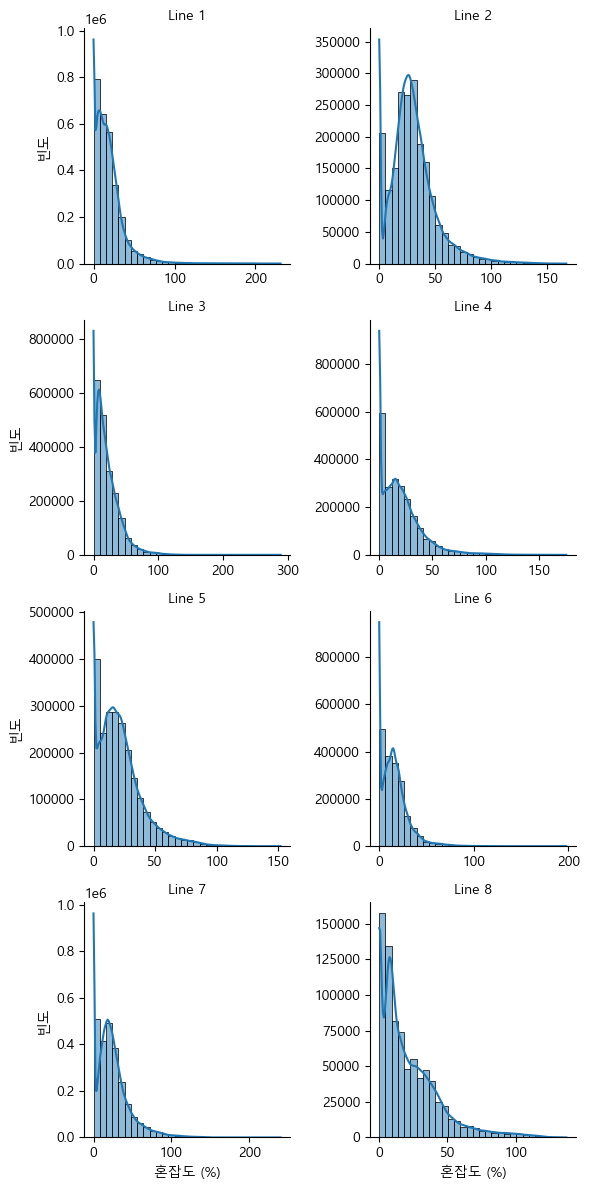

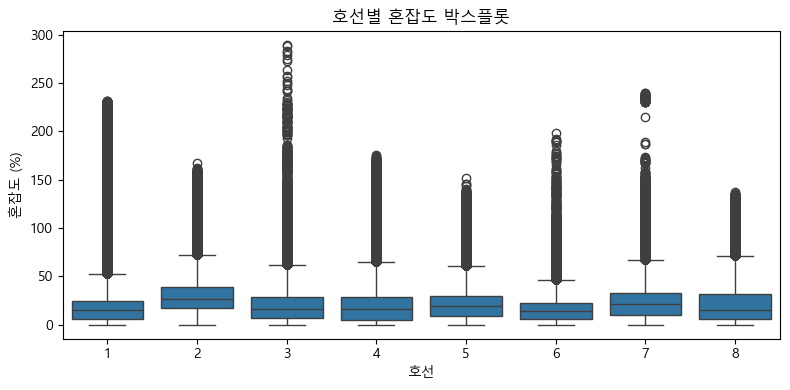

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4행×2열 FacetGrid
g = sns.FacetGrid(df, col='Line', col_wrap=2, height=3, sharex=False, sharey=False)
g.map(sns.histplot, 'Congestion', bins=30, kde=True)
g.set_titles('Line {col_name}')
g.set_axis_labels('혼잡도 (%)','빈도')
plt.tight_layout()
plt.show()

# 호선별 박스플롯은 그대로
plt.figure(figsize=(8,4))
sns.boxplot(x='Line', y='Congestion', data=df)
plt.title('호선별 혼잡도 박스플롯')
plt.xlabel('호선')
plt.ylabel('혼잡도 (%)')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# (이전까지 df, feature_cols, cat_cols, target_col 정의 및 create_features 적용 가정)

# 하이퍼파라미터 분포
param_dist = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [8, 10, 12],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [0.3, 0.5, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 3]
}

# 7호선만 필터링
line = 7
df_line = df[df['Line'] == line].sort_values('TM')

# Feature / target 추출 및 인코딩
X = pd.get_dummies(df_line[feature_cols], columns=cat_cols, drop_first=False)
y = df_line[target_col].astype(int)

# 스케일링
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X).astype(np.float32)

# XGB 모델과 RandomizedSearchCV 세팅
xgb = XGBRegressor(
    tree_method='hist',
    eval_metric='rmse',
    random_state=42,
    verbosity=0
)
rnd_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 서치 실행 & 결과 출력
rnd_search.fit(X_scaled, y)
print(f"🏆 7호선 최적 파라미터: {rnd_search.best_params_}")
